In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import non_negative_parafac
import seaborn as sns
from sklearn.cluster import KMeans
import random
import torch
from sklearn.decomposition import PCA, NMF
from adjustText import adjust_text
from sklearn.metrics import silhouette_score

In [23]:
#setting a seed to maintain reproducibility

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [24]:
data = pd.read_csv("simulated_symptom_data.csv")

symptom_data = data.drop(columns=['Age', 'SymptomCount_T1', 'FullPersistence']) #columns for L-VAE

#split dataset into t1 and t2

symptom_data_t1 = symptom_data.iloc[:, :12]  #symptoms at timepoint 1
symptom_data_t2 = symptom_data.iloc[:, 12:]  #symptoms at timepoint 2


In [25]:
#stacking the two timepoints into a 3D tensor- a tensor of order 3
tensor_data = np.stack([symptom_data_t1.values, symptom_data_t2.values], axis=-1)

#converting to tensorly tensor
tensor_data = tl.tensor(tensor_data, dtype='float32')

print(f"Tensor shape: {tensor_data.shape}") #shape: (n_individuals, n_symptoms, n_timepoints)

Tensor shape: (9166, 12, 2)


In [26]:
#rank = number of latent components to be decomposed into- 3 balances the risk of overfitting and underfitting
rank = 3

#Non-Negative CP Decomposition- extracting latent structure
weights, factors = non_negative_parafac(
    tensor_data, #3d tensor being decomposed
    rank=rank, #being decomposed into 3 latent components
    init='random', #factor matrices are initialised at random
    n_iter_max=200, #maximum iterations is 200
    tol=0.000001, #tolerance level for convergence- if the change in reconstruction error between iterations is less, convergence has occurred
    random_state=seed
)

#define factor matrices: (individuals, symptoms, timepoints)
individual_factors, symptom_factors, time_factors = factors #accounting for time

In [27]:
symptom_names = [col.replace('_T2', '') for col in symptom_data_t2.columns]


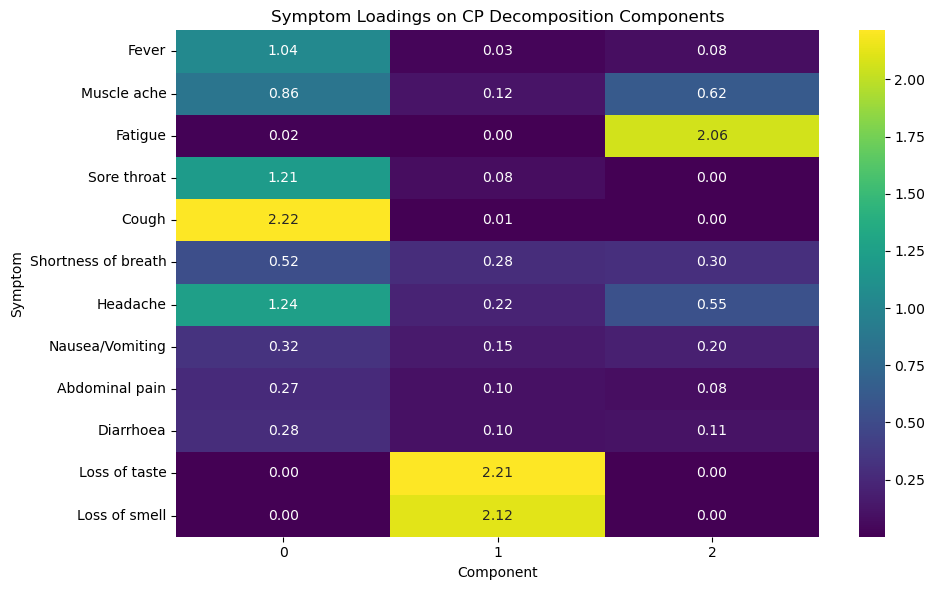

In [28]:
#outputting loadings for symptom factors

symptom_df = pd.DataFrame(symptom_factors, index=symptom_names) 

plt.figure(figsize=(10, 6))
sns.heatmap(symptom_df, annot=True, fmt=".2f", cmap="viridis")
plt.title("Symptom Loadings on CP Decomposition Components")
plt.xlabel("Component")
plt.ylabel("Symptom")
plt.tight_layout()
plt.show()


C:\Users\bdaus\AppData\Local\Temp\ipykernel_2828\835145736.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(


([Text(-0.4315271710907258, -0.26773822626897226, 'Fever'),
  Text(-0.2682120256020175, 0.2770448514393402, 'Muscle ache'),
  Text(-0.12002618213142102, 1.855759051442147, 'Fatigue'),
  Text(-0.3887428994640225, -0.4858801015785761, 'Sore throat'),
  Text(-1.054846095474497, -1.012838217616081, 'Cough'),
  Text(0.26060823870089744, 0.016860332233565645, 'Shortness of breath'),
  Text(-0.3700197700983092, -0.12234537537608814, 'Headache'),
  Text(0.2389357436770394, 0.3039502458912988, 'Nausea/Vomiting'),
  Text(0.25028519213776446, 0.11843865854399538, 'Abdominal pain'),
  Text(0.08660294634199928, 0.2191660642623905, 'Diarrhoea'),
  Text(1.7389479174210176, -0.36791736611298154, 'Loss of taste'),
  Text(1.8256386602645918, -0.2213162294455937, 'Loss of smell')],
  <matplotlib.patches.FancyArrowPatch at 0x193a4743610>])

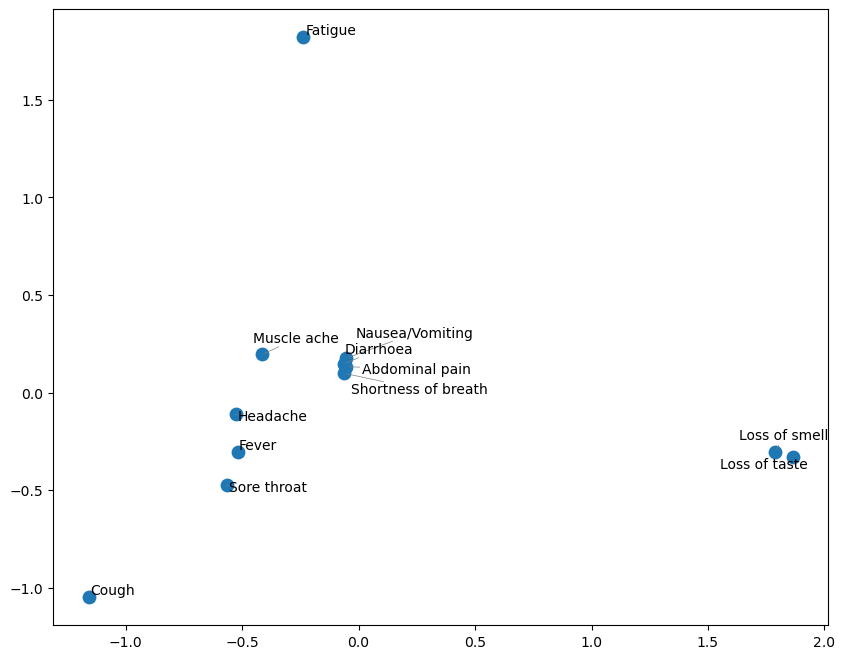

In [29]:
#reduce the three-dimensional symptom factors into 2D (for visualisation only)
pca = PCA(n_components=2, random_state=seed)
symptom_factors_2d = pca.fit_transform(symptom_factors)

df_plot = pd.DataFrame(symptom_factors_2d, columns=["PC1", "PC2"])
df_plot["Symptom"] = symptom_names

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df_plot["PC1"],
    df_plot["PC2"],
    cmap="tab10",
    s=80,
)

#annotating points
texts = []
for i, row in df_plot.iterrows():
    texts.append(
        plt.text(row["PC1"], row["PC2"], row["Symptom"], fontsize=10)
    )

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

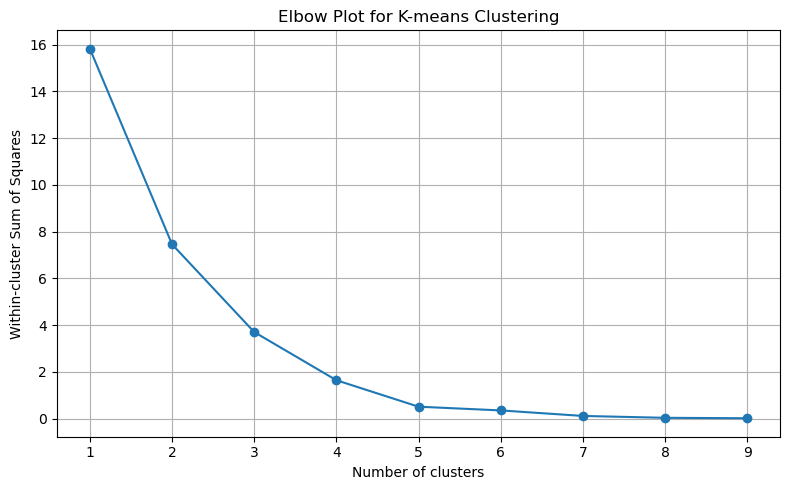

In [30]:
#elbow plot to determine optimal k for k-means clustering
cluster_range = range(1, 10)
inertia = []

#engineering K-means clustering on the symptom factors
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=seed)
    kmeans.fit(symptom_factors)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Plot for K-means Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')
plt.xticks(cluster_range)
plt.grid(True)
plt.tight_layout()
plt.show()

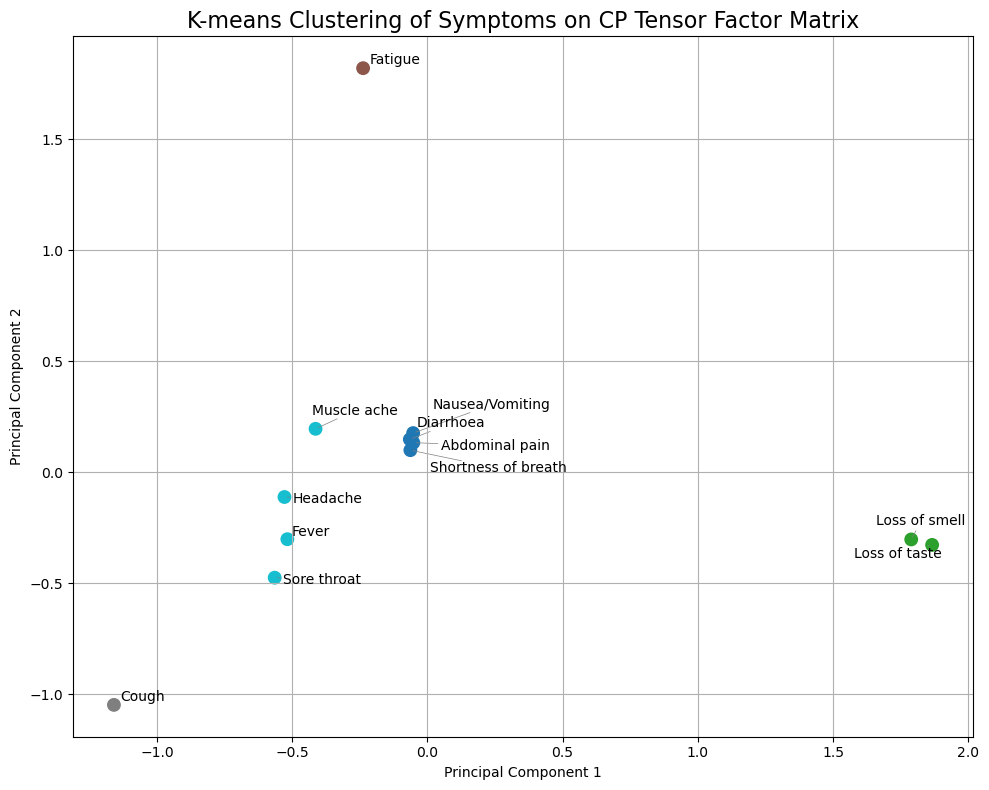

In [45]:
n_clusters = 5  #determined based on elbow plot
kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
labels = kmeans.fit_predict(symptom_factors)

#reduce the three-dimensional symptom factors into 2D (for plotting only)
pca = PCA(n_components=2, random_state=seed)
symptom_factors_2d = pca.fit_transform(symptom_factors)

df_plot = pd.DataFrame(symptom_factors_2d, columns=["PC1", "PC2"])
df_plot["Symptom"] = symptom_names
df_plot["Cluster"] = labels

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df_plot["PC1"],
    df_plot["PC2"],
    c=df_plot["Cluster"],
    cmap="tab10",
    s=80,
)

#annotating points
texts = []
for i, row in df_plot.iterrows():
    texts.append(
        plt.text(row["PC1"], row["PC2"], row["Symptom"], fontsize=10)
    )

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

plt.title("K-means Clustering of Symptoms on CP Tensor Factor Matrix", fontsize=16)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
symptom_labels = [label for label in symptom_data_t1.columns]

#shift cluster labels to start from 1 instead of 0
labels = labels + 1

symptom_clusters = pd.DataFrame({
    'Symptom': symptom_labels,
    'Cluster': labels
})

symptom_clusters = symptom_clusters.sort_values(by='Cluster').reset_index(drop=True)

print(symptom_clusters)

                Symptom  Cluster
0   Shortness of breath        1
1       Nausea/Vomiting        1
2        Abdominal pain        1
3             Diarrhoea        1
4         Loss of taste        2
5         Loss of smell        2
6               Fatigue        3
7                 Cough        4
8                 Fever        5
9           Muscle ache        5
10          Sore throat        5
11             Headache        5


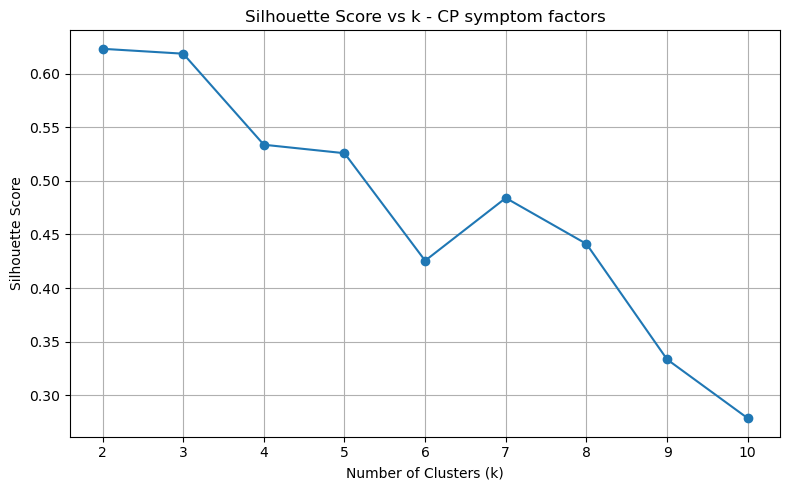

In [44]:
#silhouette scores
k_values = range(2, 11)
scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=1)
    labels = km.fit_predict(symptom_factors)
    score = silhouette_score(symptom_factors, labels)
    scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_values, scores, marker='o')
plt.title("Silhouette Score vs k - CP symptom factors")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(list(k_values))
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
labels = kmeans.fit_predict(symptom_factors)

# Compute silhouette score
score = silhouette_score(symptom_factors, labels)
print(f"Silhouette score for k=5: {score:.3f}")

Silhouette score for k=5: 0.526


In [35]:
#NMF where T1+T2 are treated as independent samples

X_nmf = np.vstack([symptom_data_t1.values, symptom_data_t2.values]).astype(float)

nmf_rank = 3
nmf = NMF(n_components=nmf_rank, random_state=seed)
W = nmf.fit_transform(X_nmf)
H = nmf.components_

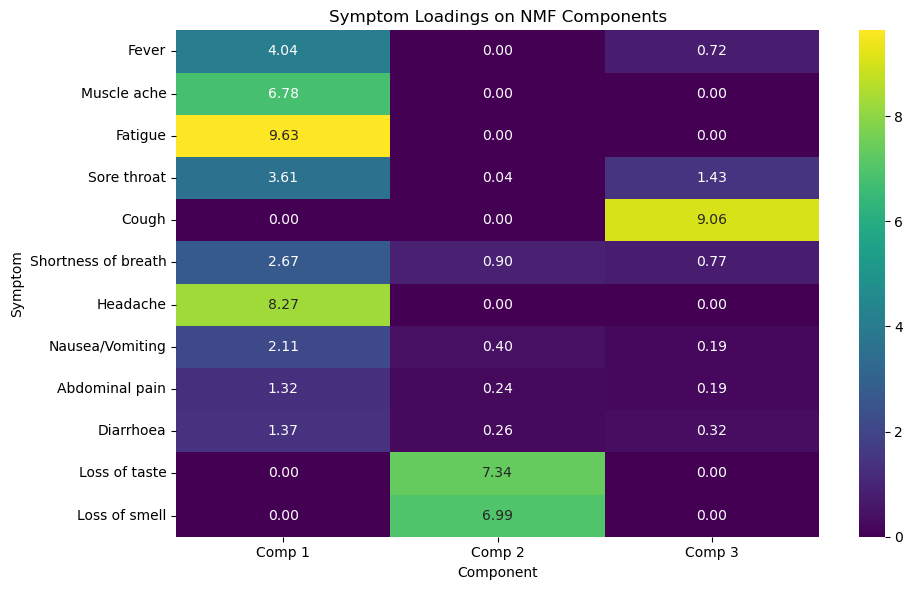

In [36]:
symptom_factors_nmf = H.T

symptom_df_nmf = pd.DataFrame(symptom_factors_nmf, index=symptom_names, columns=[f"Comp {i+1}" for i in range(nmf_rank)])
plt.figure(figsize=(10, 6))
sns.heatmap(symptom_df_nmf, annot=True, fmt=".2f", cmap="viridis")
plt.title("Symptom Loadings on NMF Components")
plt.xlabel("Component")
plt.ylabel("Symptom")
plt.tight_layout()
plt.show()


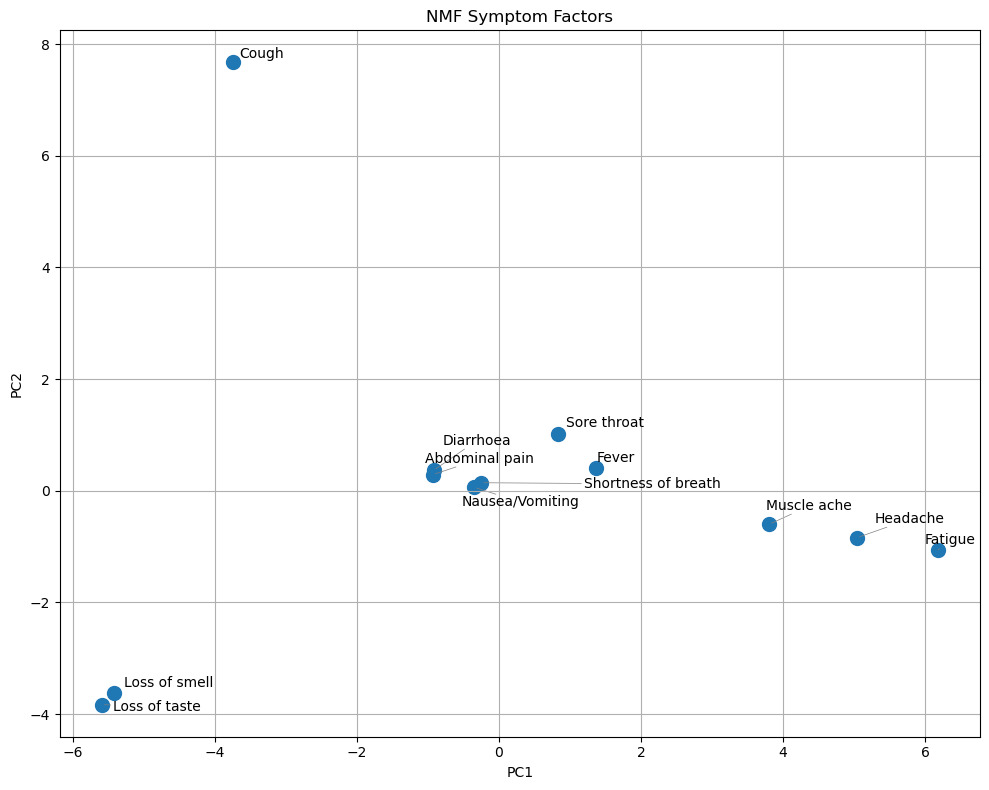

In [39]:
#2D visualisation of symptom factors (PCA just for plotting)
pca = PCA(n_components=2, random_state=seed)
symptom_factors_nmf_2d = pca.fit_transform(symptom_factors_nmf)

df_plot_nmf = pd.DataFrame(symptom_factors_nmf_2d, columns=["PC1", "PC2"])
df_plot_nmf["Symptom"] = symptom_names

plt.figure(figsize=(10, 8))
plt.scatter(df_plot_nmf["PC1"], df_plot_nmf["PC2"], s=100)
texts = [plt.text(r.PC1, r.PC2, r.Symptom, fontsize=10) for _, r in df_plot_nmf.iterrows()]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))
plt.title("NMF Symptom Factors")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

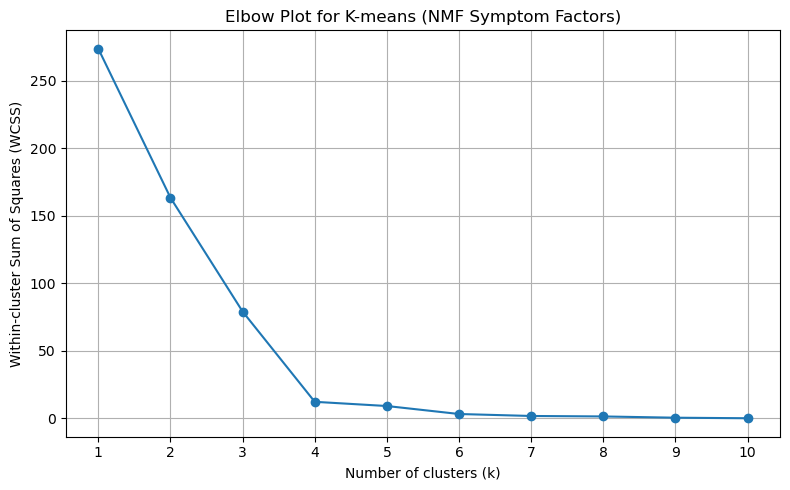

In [40]:
k_values = range(1, 11)
inertia = []
for k in k_values:
    km = KMeans(n_clusters=k, random_state=seed)
    km.fit(symptom_factors_nmf)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Plot for K-means (NMF Symptom Factors)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.xticks(list(k_values))
plt.grid(True)
plt.tight_layout()
plt.show()

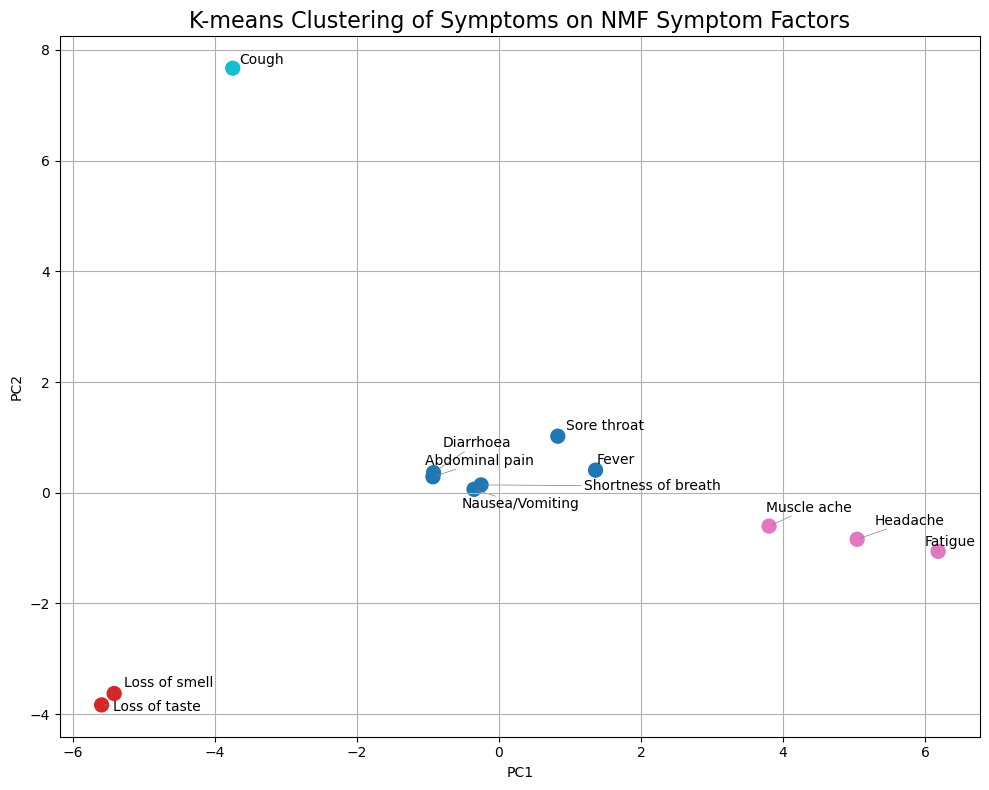

In [43]:
km_final = KMeans(n_clusters=4, random_state=seed)
labels_nmf = km_final.fit_predict(symptom_factors_nmf)

df_plot_nmf["Cluster"] = labels_nmf
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df_plot_nmf["PC1"], df_plot_nmf["PC2"],
    c=df_plot_nmf["Cluster"], cmap="tab10", s=100
)
texts = [plt.text(r.PC1, r.PC2, r.Symptom, fontsize=10) for _, r in df_plot_nmf.iterrows()]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))
plt.title("K-means Clustering of Symptoms on NMF Symptom Factors", fontsize=16)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [70]:
symptom_clusters_nmf = (
    pd.DataFrame({"Symptom": symptom_names, "Cluster": labels_nmf + 1})
      .sort_values("Cluster")
      .reset_index(drop=True)
)
print(symptom_clusters_nmf)

                Symptom  Cluster
0                 Fever        1
1           Sore throat        1
2   Shortness of breath        1
3       Nausea/Vomiting        1
4        Abdominal pain        1
5             Diarrhoea        1
6         Loss of taste        2
7         Loss of smell        2
8           Muscle ache        3
9               Fatigue        3
10             Headache        3
11                Cough        4


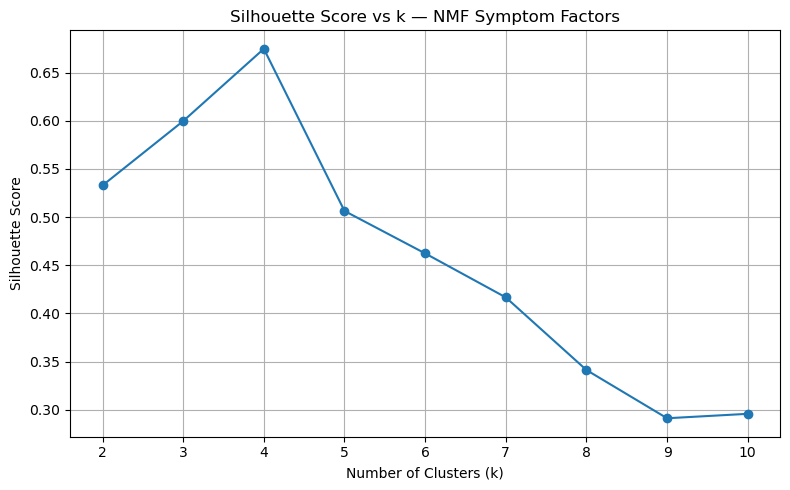

In [71]:
sil_scores = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=seed)
    lbls = km.fit_predict(symptom_factors_nmf)
    sil_scores.append(silhouette_score(symptom_factors_nmf, lbls))

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), sil_scores, marker='o')
plt.title("Silhouette Score vs k — NMF Symptom Factors")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(list(range(2, 11)))
plt.grid(True)
plt.tight_layout()
plt.show()

In [72]:
sil_final = silhouette_score(symptom_factors_nmf, labels_nmf)
print(f"Silhouette score for NMF symptom factors, k={4}: {sil_final:.3f}")

Silhouette score for NMF symptom factors, k=4: 0.675
